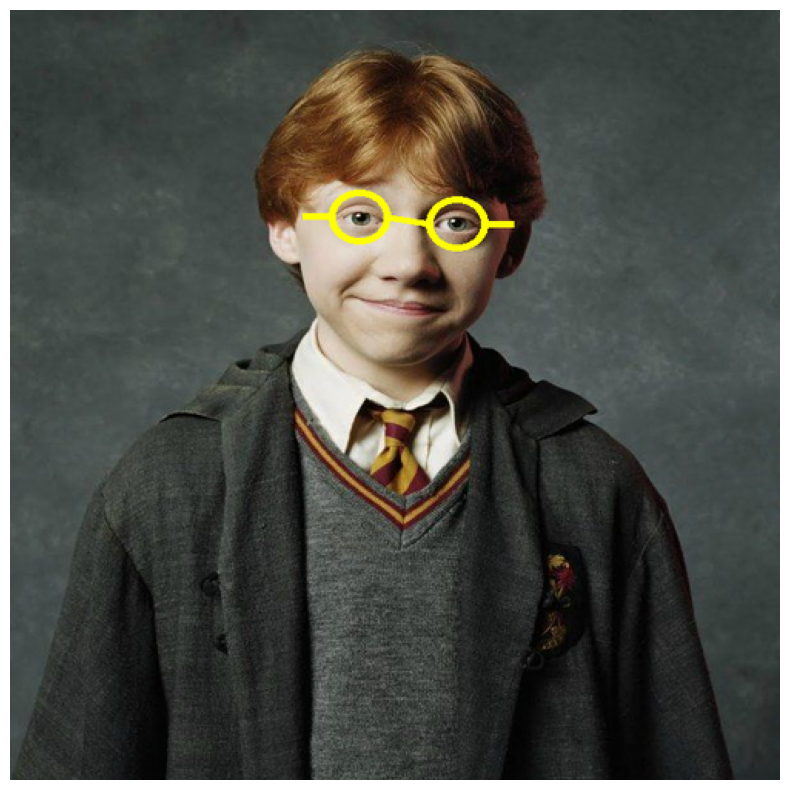

In [3]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

def load_data(filename):
    return pd.read_excel(filename)

def get_variant(df, variant):
    return df.iloc[variant - 1]

def process_image(image_path, image_size, glasses_color, line_width, output_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image {image_path} not found.")
        
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face_region = img[y:y+h, x:x+w]
        face_gray = gray[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(face_gray)
        if len(eyes) == 2:
            eyes = sorted(eyes, key=lambda e: e[0])
            face_pil = Image.fromarray(cv2.cvtColor(face_region, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(face_pil)
            left_eye = eyes[0]
            right_eye = eyes[1]
            
            for (ex, ey, ew, eh) in eyes:
                eye_center = (ex + ew // 2, ey + eh // 2)
                radius = ew // 2
                draw.ellipse(
                    [(eye_center[0] - radius, eye_center[1] - radius),
                    (eye_center[0] + radius, eye_center[1] + radius)],
                    outline=glasses_color, width=line_width)
                
                left_eye_center = (left_eye[0] + left_eye[2] // 2, left_eye[1] + left_eye[3] // 2)
                right_eye_center = (right_eye[0] + right_eye[2] // 2, right_eye[1] + right_eye[3] // 2)
                
                bridge_start = (left_eye_center[0] + int(0.3 * (right_eye_center[0] - left_eye_center[0])), left_eye_center[1])
                bridge_end = (right_eye_center[0] - int(0.3 * (right_eye_center[0] - left_eye_center[0])), right_eye_center[1])
                
                draw.line([bridge_start, bridge_end], fill=glasses_color, width=line_width)
                draw.line(
                    [left_eye_center[0] - radius, left_eye_center[1],
                    left_eye_center[0] - radius - 20, left_eye_center[1]],
                    fill=glasses_color, width=line_width)
                draw.line(
                    [right_eye_center[0] + radius, right_eye_center[1],
                    right_eye_center[0] + radius + 20, right_eye_center[1]],
                    fill=glasses_color, width=line_width)
                face_region = cv2.cvtColor(np.array(face_pil), cv2.COLOR_RGB2BGR)
                img[y:y+h, x:x+w] = face_region
        
        new_width, new_height = map(int, image_size.split('x'))
        pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        pil_img = pil_img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        img_resized = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        img_resized = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        
        cv2.imwrite(output_path, img_resized)
        display_image(img_resized)

def display_image(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    data = load_data("lab6.xlsx")
    N = ord('O') % 5 + 1
    variant_data = get_variant(data, N)
    image_folder = "images"
    image_path = os.path.join(image_folder, variant_data['file name'])
    image_size = variant_data['image size']
    glasses_color = variant_data['glasses color']
    line_width = int(variant_data['line width'])
    output_path = os.path.join(image_folder, f"processes_{variant_data['file name']}")
    if os.path.exists(image_path):
        process_image(image_path, image_size, glasses_color, line_width, output_path)
    else:
        print(f"File {image_path} does not exist.")